## Chronos_Fx-Variable Importance


In [ ]:
pip install chronos-forecasting

In [ ]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'Q', 'd_pi', 'dI_t', 'Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – past covariates) ===
Observations: 308
RMSE (level): 0.142228
MAE  (level): 0.096282
Directional accuracy: 210/307 (68.4%)

=== Diebold–Mariano vs Random Walk (monthly, past covariates) ===
Loss: MSE | horizon h=1
DM-statistic: -2.5441
p-value     : 0.0110


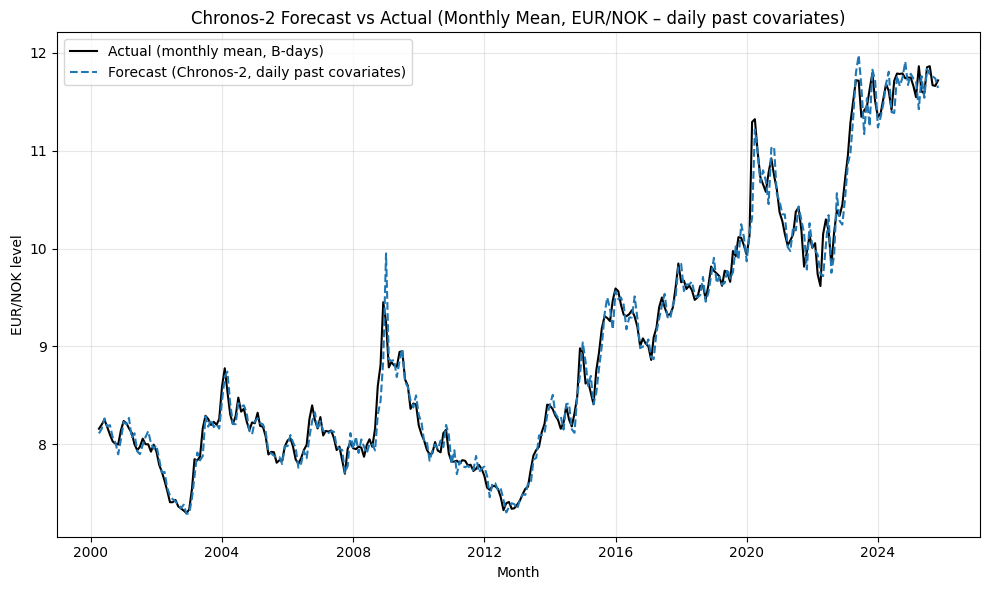

Saved: Chronos2M_daily_pastcov.png
Saved: Chronos2M_daily_pastcov.pdf

[Sequential importance] Baseline: full model with all covariates

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – past covariates) ===
Observations: 308
RMSE (level): 0.142228
MAE  (level): 0.096282
Directional accuracy: 210/307 (68.4%)

[Sequential importance] Step 1
  Active covariates: ['Q', 'd_pi', 'dI_t', 'Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']
  Testing removal of covariate: Q

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – past covariates) ===
Observations: 308
RMSE (level): 0.141548
MAE  (level): 0.095989
Directional accuracy: 212/307 (69.1%)
  Testing removal of covariate: d_pi

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model perfor

In [7]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily past covariates
+ sequential backward variable importance (macro + financial covariates).

Univariate setup:
  - Target: EUR_NOK (single series)
  - Covariates (past-only, no future_df):
      * Macros: Q, d_pi, dI_t
      * Financials: Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy
  - Data: daily observations
  - Cut: last business day of previous month (based on EUR_NOK B-days)
  - Forecast: next calendar month at daily frequency,
              aggregated to monthly mean over business days (EUR/NOK only)

Variable importance:
  - Global sequential backward elimination on:
      * All covariates: Q, d_pi, dI_t, Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy
  - At each step:
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # from chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"          # monthly evaluation
    min_hist_days: int = 40    # minimum number of daily obs before first forecast
    max_context: int = 2048
    max_horizon: int = 64      # must exceed longest month (~31 days); 64 is a safe margin
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_pastcov.png"
    fig_pdf: str = "Chronos2M_daily_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"

MACRO_COLS = ["Q", "d_pi", "dI_t"]
EXOG_COLS = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
COV_COLS = MACRO_COLS + EXOG_COLS


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily EUR_NOK + covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t, Brent, VIX,
      StoxEurope, SP500, OSEBX, OBX_Energy

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cut and monthly ground truth)
      DF_d : daily wide DataFrame with columns [EUR_NOK] + COV_COLS
             (calendar days, forward-filled)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {
        "Date", "EUR_NOK", "Q", "d_pi", "dI_t",
        "Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"
    }
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    for col in ["EUR_NOK"] + COV_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["EUR_NOK"])

    # Business-day EUR_NOK (ground truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    # Hold kun target + kovariater
    DF_d = DF_d[[TARGET_SERIES] + COV_COLS].copy()

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Chronos-2 model builder (univariate + past covariates)
# -----------------------------
def build_model_chronos2_pastcov(
    max_context: int,
    horizon_len: int,
) -> Callable[[pd.DataFrame, int], np.ndarray]:
    """
    Build a Chronos-2 forecasting function for a single EUR_NOK daily series
    with past-only covariates (COV_COLS).

    Returns:
      forecast_fn(hist_df, H) -> np.ndarray length H (daily point forecasts)

    hist_df:
      index  : DATE (daily, up to and including cut)
      columns: [EUR_NOK] + COV_COLS
    """
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install a CUDA build of PyTorch and a recent NVIDIA driver.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            y = df["0.5"].to_numpy()
        elif "predictions" in df.columns:
            y = df["predictions"].to_numpy()
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            y = df["forecast"].to_numpy()
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    y = df[cand].to_numpy()
                    break
            else:
                raise RuntimeError(f"Chronos2 predict_df: unsupported schema. Columns={list(df.columns)}.")

        return np.asarray(y, dtype=float)

    def _forecast(hist_df: pd.DataFrame, H: int) -> np.ndarray:
        # Begrens konteksten
        ctx = hist_df.tail(max_context).copy()

        # Forbered input til Chronos-2
        df_ctx = ctx.reset_index().rename(columns={"DATE": "timestamp", TARGET_SERIES: "target"})
        df_ctx["item_id"] = TARGET_SERIES

        cols = ["item_id", "timestamp", "target"] + COV_COLS
        df_ctx = df_ctx[cols]

        with torch.inference_mode():
            pred = pipeline.predict_df(
                df_ctx,
                prediction_length=H,
                quantile_levels=[0.5],  # median only
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                # Ingen future_df: alle COV_COLS tolkes som past covariates
            )

        med = _extract_median(pred)
        return med[:H]

    return _forecast


# -----------------------------
# Monthly walk-forward (univariate + past covariates)
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], np.ndarray],
) -> pd.DataFrame:
    """
    Monthly walk-forward evaluation based on daily EUR_NOK forecasts
    with past-only covariates.

    For each calendar month m:
      - Cut at last business day of previous month (based on S_b).
      - Use all daily observations up to and including cut (DF_d) as history:
          EUR_NOK as target, COV_COLS as past covariates.
      - Forecast the full next calendar month at daily frequency.
      - Aggregate EUR_NOK forecasts til monthly mean over business days.
      - Compare med faktisk EUR_NOK månedlig gjennomsnitt (S_b).
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        # Historikk opp til cut
        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        # B-dager i mål-måned
        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        # Horisont = antall kalenderdager i måneden
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        # Forecast H dager frem
        pf = forecast_fn(hist_df, H)
        if pf.shape[0] < H:
            dropped[str(m)] = f"horizon_short({pf.shape[0]})"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx, name="point")

        # Aggreger til B-dager i måneden
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df


# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    # Directional accuracy vs previous month
    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – past covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Helper: metrics for tables
# -----------------------------
def compute_metrics_for_table(eval_df: pd.DataFrame) -> Dict[str, float]:
    """
    Compute RMSE, MAE, directional accuracy and MSFE ratio vs RW
    from an eval_df with columns ['y_true', 'y_pred'].
    """
    df = eval_df.copy().dropna(subset=["y_true", "y_pred"])
    n_obs = int(len(df))
    if n_obs == 0:
        return {
            "n_obs": 0,
            "rmse": np.nan,
            "mae": np.nan,
            "hit_rate": np.nan,
            "msfe_model": np.nan,
            "msfe_rw": np.nan,
            "msfe_ratio": np.nan,
        }

    err = df["y_true"] - df["y_pred"]
    rmse = float(np.sqrt(np.mean(err ** 2)))
    mae = float(mean_absolute_error(df["y_true"], df["y_pred"]))

    df["y_prev"] = df["y_true"].shift(1)
    mask = df["y_prev"].notna()
    if mask.any():
        dir_true = np.sign(df.loc[mask, "y_true"] - df.loc[mask, "y_prev"])
        dir_pred = np.sign(df.loc[mask, "y_pred"] - df.loc[mask, "y_prev"])
        hits = int((dir_true.values == dir_pred.values).sum())
        total = int(mask.sum())
        hit_rate = hits / total
    else:
        hit_rate = np.nan

    # Random walk = forrige måneds nivå
    df["rw_pred"] = df["y_true"].shift(1)
    df_rw = df.dropna(subset=["rw_pred"])
    if len(df_rw) > 0:
        e_model = df_rw["y_true"] - df_rw["y_pred"]
        e_rw = df_rw["y_true"] - df_rw["rw_pred"]
        msfe_model = float(np.mean(e_model ** 2))
        msfe_rw = float(np.mean(e_rw ** 2))
        msfe_ratio = msfe_model / msfe_rw if msfe_rw > 0 else np.nan
    else:
        msfe_model = msfe_rw = msfe_ratio = np.nan

    return {
        "n_obs": n_obs,
        "rmse": rmse,
        "mae": mae,
        "hit_rate": hit_rate,
        "msfe_model": msfe_model,
        "msfe_rw": msfe_rw,
        "msfe_ratio": msfe_ratio,
    }


# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(
    eval_df: pd.DataFrame,
    loss: str = "mse",
    h: int = 1,
    return_stats: bool = False,
) -> Optional[Tuple[float, float]]:
    """Random walk benchmark: previous month's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (monthly, past covariates) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

    if return_stats:
        return dm_stat, p_val
    return None


# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (monthly mean, EUR/NOK)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, daily past covariates)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – daily past covariates)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Sequential backward variable importance (past covariates)
# -----------------------------
def sequential_backward_importance_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], np.ndarray],
    cov_cols: Optional[List[str]] = None,
) -> pd.DataFrame:
    """
    Sequential backward elimination på kovariater:
      - cov_cols = COV_COLS (Q, d_pi, dI_t, Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy)

    Ved hvert steg:
      - For hver gjenværende kovariat:
          * Sett kolonnen til konstant (globalt gjennomsnitt) i DF_d.
          * Kjør full månedlig walk-forward.
          * Beregn RMSE, MAE, hit_rate, MSFE-ratio, DM-stat.
      - Velg variabelen hvor RMSE øker minst relativt til gjeldende konfigurasjon.
    """
    if cov_cols is None:
        cov_cols = list(COV_COLS)
    else:
        cov_cols = list(cov_cols)

    def _set_cov_constant(df: pd.DataFrame, col: str) -> None:
        const_value = float(df[col].mean())
        df[col] = const_value

    # Baseline: full modell med alle kovariater
    print("\n[Sequential importance] Baseline: full model with all covariates")
    df_eval_full = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn)
    eval_full = evaluate(df_eval_full)
    metrics_full = compute_metrics_for_table(eval_full)

    current_covs = cov_cols.copy()
    current_df = DF_d.copy()
    current_metrics = metrics_full

    steps_records: List[Dict] = []
    step = 0

    while len(current_covs) > 0:
        step += 1
        print(f"\n[Sequential importance] Step {step}")
        print(f"  Active covariates: {current_covs}")

        candidate_results = []

        for cov in current_covs:
            print(f"  Testing removal of covariate: {cov}")
            df_test = current_df.copy()
            _set_cov_constant(df_test, cov)

            df_eval_test = walk_forward_chronos2_monthly_pastcov(S_b, df_test, forecast_fn)
            eval_test = evaluate(df_eval_test)
            m = compute_metrics_for_table(eval_test)

            dm_stat, dm_pval = dm_test(
                y_true=eval_test["y_true"],
                y_model=eval_test["y_pred"],
                y_rw=eval_test["y_true"].shift(1),
                h=1,
                loss="mse",
            )

            delta_rmse = m["rmse"] - current_metrics["rmse"]
            delta_msfe = m["msfe_ratio"] - current_metrics["msfe_ratio"]

            candidate_results.append(
                {
                    "variable_name": cov,
                    "variable_type": "macro" if cov in MACRO_COLS else "exog",
                    "metrics": m,
                    "dm_stat": dm_stat,
                    "dm_pval": dm_pval,
                    "delta_rmse": delta_rmse,
                    "delta_msfe_ratio": delta_msfe,
                    "df_state": df_test,
                }
            )

        # Velg variabel med minst forverring i RMSE
        best = min(candidate_results, key=lambda d: d["delta_rmse"])
        var_name = best["variable_name"]
        var_type = best["variable_type"]
        m_star = best["metrics"]
        dm_star = best["dm_stat"]
        pv_star = best["dm_pval"]
        delta_rmse_star = best["delta_rmse"]
        delta_msfe_star = best["delta_msfe_ratio"]
        df_star = best["df_state"]

        remaining_covs = [c for c in current_covs if c != var_name]

        print(f"  -> Removing {var_type}: {var_name}")
        print(f"     New RMSE: {m_star['rmse']:.6f} (ΔRMSE from prev: {delta_rmse_star:+.6f})")
        print(f"     New MSFE ratio: {m_star['msfe_ratio']:.6f} (Δ: {delta_msfe_star:+.6f})")

        steps_records.append(
            {
                "step": step,
                "variable_name": var_name,
                "variable_type": var_type,
                "remaining_covariates": ", ".join(remaining_covs) if remaining_covs else "None",
                "n_obs": m_star["n_obs"],
                "rmse": m_star["rmse"],
                "mae": m_star["mae"],
                "hit_rate": m_star["hit_rate"],
                "msfe_model": m_star["msfe_model"],
                "msfe_rw": m_star["msfe_rw"],
                "msfe_ratio": m_star["msfe_ratio"],
                "dm_stat": dm_star,
                "dm_pval": pv_star,
                "delta_rmse_from_prev": delta_rmse_star,
                "delta_msfe_ratio_from_prev": delta_msfe_star,
            }
        )

        # Oppdater state
        current_df = df_star
        current_covs = remaining_covs
        current_metrics = m_star

    steps_df = pd.DataFrame.from_records(steps_records).set_index("step")

    # Importance ranking: siste som fjernes = mest viktig
    steps_df["importance_rank"] = len(steps_df) - steps_df.index + 1
    return steps_df


# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Build model (Chronos-2) – univariate EUR_NOK + daily past covariates
    forecast_fn = build_model_chronos2_pastcov(
        max_context=CFG.max_context,
        horizon_len=min(CFG.max_horizon, 64),
    )

    # 3) Monthly walk-forward (past covariates) and evaluation – full model
    df_eval = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn)
    eval_df = evaluate(df_eval)

    # 4) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 5) Plot results
    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

    # 6) Sequential backward variable importance (past covariates)
    steps_df = sequential_backward_importance_pastcov(
        S_b,
        DF_d,
        forecast_fn,
        cov_cols=COV_COLS,
    )

    print("\n=== Sequential backward variable importance (monthly, Chronos-2 past covariates) ===")
    steps_to_print = steps_df.copy()
    steps_to_print["hit_rate"] = steps_to_print["hit_rate"] * 100.0

    print(
        steps_to_print.to_string(
            float_format=lambda x: f"{x: .6f}"
        )
    )


if __name__ == "__main__":
    main()


Data (M): 2000-01-31 → 2025-11-30 | n=311
Columns (DF_m): ['EUR_NOK', 'Q', 'd_pi', 'dI_t', 'Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']
Exogenous columns present: ['Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']

Dropped quarters and reasons:
  2000Q1: no_month_in_prev_quarter
  2000Q2: hist<36
  2000Q3: hist<36
  2000Q4: hist<36
  2001Q1: hist<36
  2001Q2: hist<36
  2001Q3: hist<36
  2001Q4: hist<36
  2002Q1: hist<36
  2002Q2: hist<36
  2002Q3: hist<36
  2002Q4: hist<36

=== Model performance (quarterly mean, EUR/NOK – monthly macro + exogenous covariates) ===
Observations: 92
RMSE (level): 0.277243
MAE  (level): 0.193941
Directional accuracy: 58.2%

=== Diebold–Mariano vs Random Walk (quarterly, monthly macros+exog) ===
Loss: MSE | horizon h=1
DM-statistic: 0.4331
p-value     : 0.6649


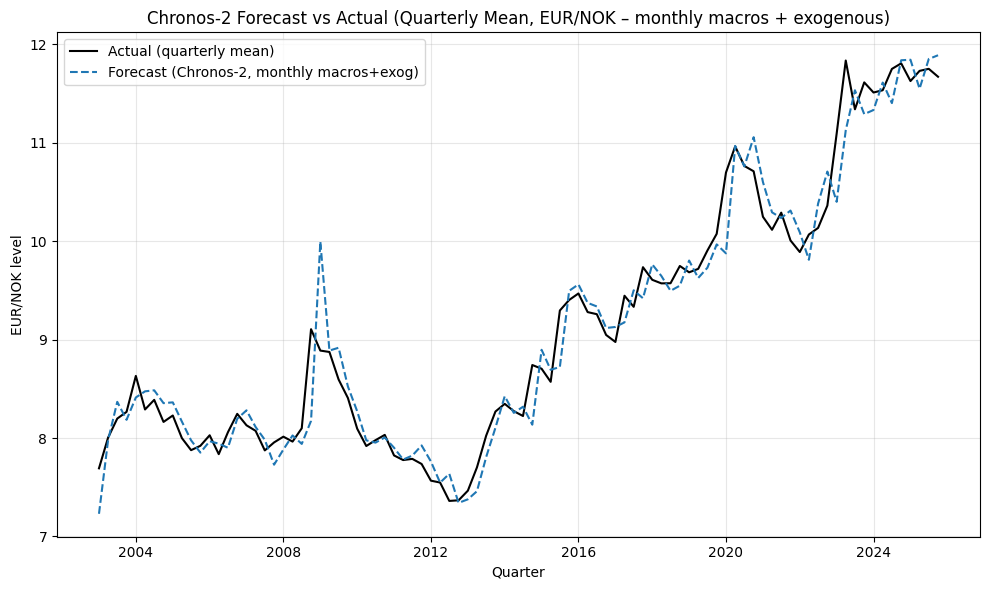

Saved: Chronos2Q_monthly_pastcov.png
Saved: Chronos2Q_monthly_pastcov.pdf

[Sequential importance – quarterly Chronos-2 (monthly macros + exogenous)]
  Initial macros   : ['Q', 'd_pi', 'dI_t']
  Initial exogenous: ['Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']

Dropped quarters and reasons:
  2000Q1: no_month_in_prev_quarter
  2000Q2: hist<36
  2000Q3: hist<36
  2000Q4: hist<36
  2001Q1: hist<36
  2001Q2: hist<36
  2001Q3: hist<36
  2001Q4: hist<36
  2002Q1: hist<36
  2002Q2: hist<36
  2002Q3: hist<36
  2002Q4: hist<36

[Sequential importance] Step 1
  Active macros   : ['Q', 'd_pi', 'dI_t']
  Active exogenous: ['Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']
  Testing removal of macro: Q

Dropped quarters and reasons:
  2000Q1: no_month_in_prev_quarter
  2000Q2: hist<36
  2000Q3: hist<36
  2000Q4: hist<36
  2001Q1: hist<36
  2001Q2: hist<36
  2001Q3: hist<36
  2001Q4: hist<36
  2002Q1: hist<36
  2002Q2: hist<36
  2002Q3: hist<36
  2002Q4: hist<36
  Testin

In [6]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels) with monthly macro + exogenous covariates
+ sequential backward variable importance on Q, d_pi, dI_t and financial exogenous series.

Univariate setup:
  - Target: EUR_NOK (single series)
  - Macros: Q, d_pi, dI_t as past-only covariates
  - Exogenous: Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy as past-only covariates
  - Data: monthly observations (EUR_NOK + macros + exogenous)
  - Cut: last month of previous quarter
  - Forecast: next calendar quarter at monthly frequency (H months),
              aggregated to quarterly mean (EUR/NOK)
  - No future_df passed to Chronos-2 -> no leakage from future macro paths
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # from chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"
    )
    q_freq: str = "Q-DEC"      # quarterly evaluation
    min_hist_months: int = 36  # minimum number of monthly obs before first forecast
    max_context: int = 512
    max_horizon: int = 6       # must exceed longest quarter in months (~3), 6 is a safe margin
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_monthly_pastcov.png"
    fig_pdf: str = "Chronos2Q_monthly_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]

# Exogenous (financial) covariates – used if present in the monthly CSV
EXOG_COLS = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: monthly EUR/NOK + macro + exogenous covariates
# -----------------------------
def load_series_monthly(url: str) -> Tuple[pd.Series, pd.DataFrame, List[str]]:
    """
    Load monthly CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t, and optionally exogenous financial series.

    Returns:
      S_m         : EUR_NOK monthly series
      DF_m        : monthly DataFrame with EUR_NOK + MACRO_COLS + available EXOG_COLS
      exog_cols   : list of exogenous columns actually present in the file
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    base_required = ["Date", "EUR_NOK"] + MACRO_COLS
    missing_base = set(base_required) - set(raw.columns)
    if missing_base:
        raise ValueError(f"Missing required columns in monthly CSV: {missing_base}. Got: {list(raw.columns)}")

    # Only keep exogenous columns that exist in the file
    exog_present = [c for c in EXOG_COLS if c in raw.columns]

    keep_cols = base_required + exog_present
    df = (
        raw[keep_cols]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    num_cols = [c for c in keep_cols if c != "Date"]
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(subset=["EUR_NOK"])

    DF_m = df.copy()
    DF_m.index.name = "DATE"

    S_m = DF_m[TARGET_SERIES].astype(float)
    S_m.name = TARGET_SERIES

    return S_m, DF_m, exog_present


# -----------------------------
# Chronos-2: base pipeline
# -----------------------------
def build_base_chronos_pipeline() -> BaseChronosPipeline:
    """Load the base Chronos-2 pipeline on CUDA in fp16."""
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install a CUDA build of PyTorch and a recent NVIDIA driver.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )
    return pipeline


# -----------------------------
# Chronos-2 model builder (univariate + past-only covariates)
# -----------------------------
def build_model_chronos2_univariate(
    pipeline: BaseChronosPipeline,
    macro_cols: List[str],
    exog_cols: List[str],
    max_context: int,
) -> Callable[[pd.DataFrame, int], np.ndarray]:
    """
    Build a Chronos-2 forecasting function for a single EUR_NOK series
    with past-only monthly macro + exogenous covariates.

    covariates = macro_cols + exog_cols (all treated as past covariates).

    Returns:
      forecast_fn(hist_df, H) -> np.ndarray length H (monthly point forecasts)

    hist_df:
      index  : DATE (monthly, up to and including cut)
      columns: EUR_NOK + macro_cols + exog_cols
    """
    cov_cols = list(macro_cols) + list(exog_cols)

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        """Extract median forecast from Chronos output."""
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            y = df["0.5"].to_numpy()
        elif "predictions" in df.columns:
            y = df["predictions"].to_numpy()
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            y = df["forecast"].to_numpy()
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    y = df[cand].to_numpy()
                    break
            else:
                raise RuntimeError(f"Chronos2 predict_df: unsupported schema. Columns={list(df.columns)}.")

        return np.asarray(y, dtype=float)

    def _forecast(hist_df: pd.DataFrame, H: int) -> np.ndarray:
        """
        Run Chronos-2 on the EUR_NOK monthly series with covariates using only past information.

        Input:
          hist_df: DF_m.loc[:cut], monthly, columns [EUR_NOK] + cov_cols

        Output:
          np.ndarray with H monthly forecasts for EUR_NOK.
        """
        cols_needed = [TARGET_SERIES] + cov_cols
        ctx = hist_df[cols_needed].tail(max_context).copy()

        df_ctx = ctx.reset_index().rename(columns={"DATE": "timestamp", TARGET_SERIES: "target"})
        df_ctx["item_id"] = TARGET_SERIES

        cols = ["item_id", "timestamp", "target"] + cov_cols
        df_ctx = df_ctx[cols]

        with torch.inference_mode():
            pred = pipeline.predict_df(
                df_ctx,
                prediction_length=H,
                quantile_levels=[0.5],  # median only
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                # No future_df passed -> all covariates treated as past-only
            )

        med = _extract_median(pred)
        return med[:H]

    return _forecast


# -----------------------------
# Quarterly walk-forward with monthly covariates
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_m: pd.Series,
    DF_m: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], np.ndarray],
) -> pd.DataFrame:
    """
    Quarterly walk-forward evaluation based on monthly EUR/NOK forecasts with covariates.

    For each calendar quarter q:
      - Cut at last month of previous quarter.
      - Use all monthly observations up to and including cut as history.
      - Forecast the full next calendar quarter at monthly frequency (H months).
      - Aggregate EUR/NOK forecasts to the quarterly mean.
      - Compare to the actual EUR/NOK quarterly mean from S_m.
    """
    first_q = pd.Period(S_m.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_m.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    monthly_q = DF_m.index.to_period(CFG.q_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1

        # Months in previous quarter
        mask_prev = (monthly_q == prev_q)
        idx_prev = DF_m.index[mask_prev]
        if idx_prev.size < 1:
            dropped[str(q)] = "no_month_in_prev_quarter"
            continue
        cut = idx_prev.max()

        # History up to and including cut
        hist_df = DF_m.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_months:
            dropped[str(q)] = f"hist<{CFG.min_hist_months}"
            continue

        # Months in current quarter
        mask_q = (monthly_q == q)
        idx_q = DF_m.index[mask_q]
        if idx_q.size < 1:
            dropped[str(q)] = "no_month_in_quarter"
            continue

        # True quarterly mean EUR/NOK
        y_true = float(S_m.loc[idx_q].mean())

        # Horizon = number of months in this quarter
        H = idx_q.size
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        # Forecast EUR/NOK for the next quarter
        pf = forecast_fn(hist_df, H)
        if pf.shape[0] < H:
            dropped[str(q)] = f"horizon_short({pf.shape[0]})"
            continue

        pred_monthly = pd.Series(pf[:H], index=idx_q, name="point")
        y_pred = float(pred_monthly.mean())

        rows[str(q)] = {"quarter": q, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if q not in df.index]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")
    return df


# -----------------------------
# DM test (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (np.abs(e_m) - np.abs(e_r)) if loss.lower() == "mae" else (e_m**2 - e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


# -----------------------------
# Metrics helper (silent)
# -----------------------------
def compute_quarterly_metrics_silent(eval_df: pd.DataFrame) -> Dict[str, float]:
    """
    Compute RMSE, MAE, MSFE(model), MSFE(RW), MSFE ratio, DM and hit-rate
    without printing (used inside variable-importance loop).
    """
    df = eval_df.copy().dropna(subset=["y_true", "y_pred"])
    n_obs = int(len(df))
    if n_obs == 0:
        return {
            "n_obs": 0,
            "rmse": np.nan,
            "mae": np.nan,
            "hit_rate": np.nan,
            "msfe_model": np.nan,
            "msfe_rw": np.nan,
            "msfe_ratio": np.nan,
            "dm_stat": np.nan,
            "dm_pval": np.nan,
        }

    err = df["y_true"] - df["y_pred"]
    rmse = float(np.sqrt(np.mean(np.square(err))))
    mae = float(mean_absolute_error(df["y_true"], df["y_pred"]))

    # Directional accuracy vs previous quarter
    df["y_prev"] = df["y_true"].shift(1)
    mask = df["y_prev"].notna()
    if mask.any():
        dir_true = np.sign(df.loc[mask, "y_true"] - df.loc[mask, "y_prev"])
        dir_pred = np.sign(df.loc[mask, "y_pred"] - df.loc[mask, "y_prev"])
        hit_rate = float((dir_true.values == dir_pred.values).mean())
    else:
        hit_rate = np.nan

    # Random walk baseline: previous quarter's level
    df["rw_pred"] = df["y_true"].shift(1)
    core = df.dropna(subset=["rw_pred"]).copy()
    if len(core) == 0:
        msfe_model = msfe_rw = msfe_ratio = np.nan
        dm_stat = dm_pval = np.nan
    else:
        msfe_model = float(np.mean((core["y_true"] - core["y_pred"]) ** 2))
        msfe_rw = float(np.mean((core["y_true"] - core["rw_pred"]) ** 2))
        msfe_ratio = msfe_model / msfe_rw if msfe_rw > 0 else np.nan
        dm_stat, dm_pval = dm_test(core["y_true"], core["y_pred"], core["rw_pred"], h=1, loss="mse")

    return {
        "n_obs": n_obs,
        "rmse": rmse,
        "mae": mae,
        "hit_rate": hit_rate,
        "msfe_model": msfe_model,
        "msfe_rw": msfe_rw,
        "msfe_ratio": msfe_ratio,
        "dm_stat": dm_stat,
        "dm_pval": dm_pval,
    }


# -----------------------------
# Evaluation (printed summary for baseline model)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy and print a short summary."""
    metrics = compute_quarterly_metrics_silent(eval_df)
    print("\n=== Model performance (quarterly mean, EUR/NOK – monthly macro + exogenous covariates) ===")
    print(f"Observations: {metrics['n_obs']}")
    print(f"RMSE (level): {metrics['rmse']:.6f}")
    print(f"MAE  (level): {metrics['mae']:.6f}")
    if np.isfinite(metrics["hit_rate"]):
        print(f"Directional accuracy: {metrics['hit_rate']*100:.1f}%")
    return eval_df.dropna(subset=["y_true", "y_pred"]).copy()


def dm_against_random_walk(eval_df: pd.DataFrame, h: int = 1) -> None:
    """Print DM vs Random Walk for the current eval_df."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss="mse")
    print("\n=== Diebold–Mariano vs Random Walk (quarterly, monthly macros+exog) ===")
    print(f"Loss: MSE | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value: nan")


# -----------------------------
# Sequential backward variable importance (quarterly)
# -----------------------------
def sequential_importance_quarterly_chronos2(
    S_m: pd.Series,
    DF_m: pd.DataFrame,
    pipeline: BaseChronosPipeline,
    init_macros: List[str],
    init_exog: List[str],
) -> pd.DataFrame:
    """
    Sequential backward variable importance for quarterly Chronos-2 with monthly covariates.

    At each step:
      - For each remaining variable v in {macros ∪ exog}:
          * remove v from the covariate set
          * recompute full quarterly walk-forward
          * compute RMSE, MAE, MSFE ratio, DM vs RW
      - Remove the variable whose removal yields the *best* MSFE ratio
        (least deterioration), i.e., stepwise backward elimination.
      - Record metrics and delta from the previous step.

    Returns:
      DataFrame indexed by step with columns:
        variable_name, variable_type, remaining_macros, remaining_exog,
        n_obs, rmse, mae, msfe_model, msfe_rw, msfe_ratio,
        dm_stat, dm_pval, delta_rmse_from_prev, delta_msfe_ratio_from_prev,
        importance_rank (1 = last removed, most important).
    """
    # Baseline with all variables
    all_macros = list(init_macros)
    all_exog = list(init_exog)

    print("\n[Sequential importance – quarterly Chronos-2 (monthly macros + exogenous)]")
    print(f"  Initial macros   : {all_macros}")
    print(f"  Initial exogenous: {all_exog}")

    # Helper to run model for a given covariate set
    def run_with_covars(macros: List[str], exog: List[str]) -> Tuple[pd.DataFrame, Dict[str, float]]:
        forecast_fn = build_model_chronos2_univariate(
            pipeline=pipeline,
            macro_cols=macros,
            exog_cols=exog,
            max_context=CFG.max_context,
        )
        df_eval = walk_forward_chronos2_quarterly_pastcov(S_m, DF_m, forecast_fn)
        metrics = compute_quarterly_metrics_silent(df_eval)
        return df_eval, metrics

    # Baseline metrics (full covariate set)
    _, base_metrics = run_with_covars(all_macros, all_exog)
    prev_rmse = base_metrics["rmse"]
    prev_msfe_ratio = base_metrics["msfe_ratio"]

    current_macros = list(all_macros)
    current_exog = list(all_exog)

    records: List[Dict] = []
    total_vars = len(current_macros) + len(current_exog)

    for step in range(1, total_vars + 1):
        print(f"\n[Sequential importance] Step {step}")
        print(f"  Active macros   : {current_macros}")
        print(f"  Active exogenous: {current_exog}")

        best_var = None
        best_type = None
        best_metrics = None

        # Try removing each macro
        for m in current_macros:
            trial_macros = [x for x in current_macros if x != m]
            trial_exog = list(current_exog)
            print(f"  Testing removal of macro: {m}")
            _, metrics = run_with_covars(trial_macros, trial_exog)
            if (best_metrics is None) or (metrics["msfe_ratio"] < best_metrics["msfe_ratio"]):
                best_var = m
                best_type = "macro"
                best_metrics = metrics

        # Try removing each exogenous
        for x in current_exog:
            trial_macros = list(current_macros)
            trial_exog = [z for z in current_exog if z != x]
            print(f"  Testing removal of exogenous: {x}")
            _, metrics = run_with_covars(trial_macros, trial_exog)
            if (best_metrics is None) or (metrics["msfe_ratio"] < best_metrics["msfe_ratio"]):
                best_var = x
                best_type = "fin.exog."
                best_metrics = metrics

        # After testing all candidates, remove the "least harmful" variable
        if best_var is None:
            print("  No removable variable found (should not happen).")
            break

        if best_type == "macro":
            current_macros = [m for m in current_macros if m != best_var]
        else:
            current_exog = [x for x in current_exog if x != best_var]

        delta_rmse = best_metrics["rmse"] - prev_rmse
        delta_ratio = best_metrics["msfe_ratio"] - prev_msfe_ratio

        print(f"  -> Removing {best_type}: {best_var}")
        print(f"     New RMSE      : {best_metrics['rmse']:.6f} (Δ from prev: {delta_rmse:+.6f})")
        print(f"     New MSFE ratio: {best_metrics['msfe_ratio']:.6f} (Δ: {delta_ratio:+.6f})")

        records.append(
            {
                "step": step,
                "variable_name": best_var,
                "variable_type": best_type,
                "remaining_macros": ", ".join(current_macros) if current_macros else "None",
                "remaining_exogenous": ", ".join(current_exog) if current_exog else "None",
                "n_obs": best_metrics["n_obs"],
                "rmse": best_metrics["rmse"],
                "mae": best_metrics["mae"],
                "msfe_model": best_metrics["msfe_model"],
                "msfe_rw": best_metrics["msfe_rw"],
                "msfe_ratio": best_metrics["msfe_ratio"],
                "dm_stat": best_metrics["dm_stat"],
                "dm_pval": best_metrics["dm_pval"],
                "delta_rmse_from_prev": delta_rmse,
                "delta_msfe_ratio_from_prev": delta_ratio,
            }
        )

        prev_rmse = best_metrics["rmse"]
        prev_msfe_ratio = best_metrics["msfe_ratio"]

    if not records:
        return pd.DataFrame()

    imp_df = pd.DataFrame.from_records(records).set_index("step")

    # Importance ranking: last removed = most important (rank 1)
    n_steps = len(imp_df)
    imp_df["importance_rank"] = (n_steps + 1 - imp_df.index).astype(int)

    print("\n=== Sequential backward variable importance (quarterly, Chronos-2) ===")
    print(imp_df)

    return imp_df


# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (quarterly mean, EUR/NOK)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean)")
    plt.plot(
        x,
        eval_df["y_pred"],
        color="tab:blue",
        linestyle="--",
        label="Forecast (Chronos-2, monthly macros+exog)",
    )

    plt.title("Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – monthly macros + exogenous)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load monthly data (EUR/NOK + macros + exogenous)
    S_m, DF_m, exog_present = load_series_monthly(CFG.url)
    if CFG.verbose:
        print(f"Data (M): {S_m.index.min().date()} → {S_m.index.max().date()} | n={len(S_m)}")
        print(f"Columns (DF_m): {list(DF_m.columns)}")
        print(f"Exogenous columns present: {exog_present}")

    # 2) Build Chronos-2 pipeline once
    pipeline = build_base_chronos_pipeline()

    # 3) Baseline model: all macros + all available exogenous
    forecast_fn_full = build_model_chronos2_univariate(
        pipeline=pipeline,
        macro_cols=MACRO_COLS,
        exog_cols=exog_present,
        max_context=CFG.max_context,
    )

    df_eval = walk_forward_chronos2_quarterly_pastcov(S_m, DF_m, forecast_fn_full)
    eval_df = evaluate(df_eval)
    dm_against_random_walk(eval_df, h=1)
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

    # 4) Sequential backward variable importance (quarterly)
    imp_df = sequential_importance_quarterly_chronos2(
        S_m=S_m,
        DF_m=DF_m,
        pipeline=pipeline,
        init_macros=MACRO_COLS,
        init_exog=exog_present,
    )

    # If you want to save the importance table to CSV for LaTeX:
    imp_df.to_csv("Chronos2Q_variable_importance.csv", index=True)


if __name__ == "__main__":
    main()
